In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

from data_processing import *
import data_processing as dp
import metrics
# from train import *


%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = Path('data')

In [3]:
phq9 = dp.load_phq9_targets(DATADIR / "df_phq9.csv", type='classification', target='value')
locations = load_locations(DATADIR / "df_location_ratio.csv")
demographics = load_demographics(DATADIR / "df_demographics.csv")
mobility = load_passive_mobility(DATADIR / "df_passive_mobility_features.csv")
phone = load_passive_phone(
    DATADIR / "df_passive_phone_communication_features_brighten_v2.csv"
)

In [4]:
# Check balanced accuracy instead of raw and plot distributions
# Maybe look at the distr of the RMSE for regression

# Also, maybe use the std. instead of just the mean for features
# Try to use significant cross-validation
# Maybe apply feature selection:
#    * Automatic feature selection
#    * Manual: e.g. greatly reduce the number of location categories except for work and home
# Try to see the effect of some hyperparameters of the random forest

# Use only a few initial weeks in training for some patients
# Maybe try to improve the context with previous information

# Try different targets:
#    * The original sum_phq9 (not the column sum of 9 questions)
#    * Target each question separately
from collections import defaultdict
import cv
from data_processing import *
import data_processing as dp
import metrics
import models

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

def train_cv(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=False,
    TEST_TAKE_FIRST=0,
    SEED=550,
    N_SPLIT=5,
    return_csv=False,
    use_counts=False,
    feature_selection = False,
    PREVIOUS_NUM=0,
    ALL_PREVIOUS_DATA=False,
    WEIGHTED=False,
    WEIGHTED_DAYS=True,
    EWM_HALFLIFE = '7 days',
    EWM_SPAN = 5,
    daily_reduction = ['mean'],
):
    phq9 = dp.load_phq9_targets(DATADIR / "df_phq9.csv", type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / "df_location_ratio.csv")
    demographics = load_demographics(DATADIR / "df_demographics.csv")
    mobility = load_passive_mobility(DATADIR / "df_passive_mobility_features.csv")
    phone = load_passive_phone(
        DATADIR / "df_passive_phone_communication_features_brighten_v2.csv"
    )

    # combined, merged = dp.combine(
    #     phq9,
    #     dailies=dailies,
    #     constants=[demographics],
    #     prev_phq9=False,

    # )

    combined, merged = dp.combined_additively(
        phq9,
        dailies=[
            ("locations", locations),
            # ("mobility", mobility),
                # ('phone', phone)
        ],
        constants=[demographics],
        prev_phq9=False,
        all_previous_data=ALL_PREVIOUS_DATA,
        previous_num=PREVIOUS_NUM,
        weighted=WEIGHTED,
        weighted_days=WEIGHTED_DAYS,
        ewm_halflife=EWM_HALFLIFE,
        ewm_span=EWM_SPAN,  # Specify decay in terms of span
        daily_reduction=daily_reduction,
    )
    combined = dp.rf_preprocess(combined)

    if return_csv:
        return combined

    # print('Train set shape:', x_train.shape)
    # print('Test set shape:', x_test.shape)
    # n = len(y_train) + len(y_test)
    # train_pct = len(y_train) / n * 100
    # test_pct = len(y_test) / n * 100
    # print(f'Ratio: {train_pct:.2f}%/{test_pct:.2f}%')
    # print()

    metric_dict = defaultdict(list)
    gen = (
        cv.per_patient_cv(combined, N_SPLIT, TEST_TAKE_FIRST)
        if SPLIT_BY_PARTICIPANT
        else cv.per_row_cv(combined, N_SPLIT)
    )
    for i, (x_train, x_test, y_train, y_test) in enumerate(gen):
        print(f"--- Split {i} ---")
        if x_train is None:
            print("Skipped, because take first emptied the test set.")
            continue
        if TYPE == "regression":

            def rmse(x, y):
                return np.sqrt(((x - y) ** 2).mean())

            model = RandomForestRegressor(
                n_estimators=300, n_jobs=-1, random_state=SEED
            )
            model.fit(x_train, y_train)

            train_rmse = rmse(y_train, model.predict(x_train))
            test_rmse = rmse(y_test, model.predict(x_test))
            print(f"Train set RMSE: {train_rmse:.4f}")
            print(f"Test set RMSE:  {test_rmse:.4f}")

            train_score = model.score(x_train, y_train)
            test_score = model.score(x_test, y_test)
            print(f"Train score:", train_score)
            print(f"Test score:", test_score)

            return train_score, test_score
        elif TYPE == "classification":
            if feature_selection:

                forest = RandomForestClassifier(
                n_estimators=300, n_jobs=-1, random_state=SEED
            )
                forest.fit(x_train, y_train)

                sfm = SelectFromModel(forest, threshold=0.01, prefit=True)

                # !!! WARNING: Serious hack replacing the original
                # x_train and x_test, as well as the internal model of the SKLearnRandomForest
                x_train = sfm.transform(x_train)
                x_test = sfm.transform(x_test)

            model = RandomForestClassifier(
                n_estimators=300, n_jobs=-1, random_state=SEED
            )
            model.fit(x_train, y_train)

            y_full = np.concatenate((y_train, y_test))
            random_acc = (
                100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
            )
            # train_acc = 100 * model.score(x_train, y_train)
            # test_acc = 100 * model.score(x_test, y_test)
            # print(f'Train set accuracy: {train_acc:.2f}%')
            # print(f'Test set accuracy:  {test_acc:.2f}%')
            print(f"Random full accuracy: {random_acc:.2f}%")

            # figs, axes = plt.subplots(1, 2, figsize=(16, 6))
            axes = [None, None]

            print("Train set:")
            train_bal, train_mean = metrics.accuracy_info(
                y_train,
                model.predict(x_train),
                prefix="Training",
                ax=axes[0],
                plot=False,
            )

            print("Test set:")
            test_bal, test_mean = metrics.accuracy_info(
                y_test, model.predict(x_test), prefix="Test", ax=axes[1], plot=False
            )

            metric_dict["train_bal"].append(train_bal)
            metric_dict["train_mean"].append(train_mean)
            metric_dict["test_bal"].append(test_bal)
            metric_dict["test_mean"].append(test_mean)

    for k, v in metric_dict.items():
        metric_dict[k] = np.array(v)

    return metric_dict

/Users/siyi/opt/anaconda3/envs/myepfl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Random Forest Tuning

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 400, stop = 800, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
max_samples =  [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False] 
criterion = ['squared_error', 'absolute_error', 'poisson','MAE']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples':max_samples,
               'bootstrap': bootstrap
               }
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_samples': [0.1,
                 0.2,
                 0.30000000000000004,
                 0.4,
                 0.5,
                 0.6,
                 0.7000000000000001,
                 0.8,
                 0.9,
                 1.0],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800]}


In [11]:
combined, merged = dp.combine(
    phq9,
    dailies=[
        # ("locations", locations),
        # ("mobility", mobility),
        #     # ('phone', phone)
    ],
    constants=[demographics],
    daily_reduction=['mean'],
)
combined = dp.rf_preprocess(combined)

In [122]:
combined['participant_id'].nunique()

285

In [ ]:
SEED = 433
x, y = dp.xy_split(combined)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED)
print('Train set shape:', x_train.shape)
print('Test set shape:', x_test.shape)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [119]:
rf_random.best_params_

{'n_estimators': 440,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_samples': 1.0,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

## Aggregate previous data with CV

In [12]:
def draw_train_result(test_results, train_results, test_errs, train_errs, x_label,title,show_figsize = (10,6)):
    plt.figure(figsize=show_figsize)
    tests = np.array(test_results)
    trains = np.array(train_results)
    test_errs = np.array(test_errs)
    train_errs = np.array(train_errs)

    plt.plot(x_label, trains, label='train')
    plt.plot(x_label, tests, label='test')
    plt.fill_between(x_label, trains - train_errs, trains + train_errs, alpha=0.5)
    plt.fill_between(x_label, tests - test_errs, tests + test_errs, alpha=0.5)
    plt.legend()
    plt.grid()
    plt.xlabel('N')
    plt.ylabel('Balanced Accuracy')
    plt.title(title) #not split by participant, do not take any previous role

### 1. try different reduction methods

In [32]:
reduct_method = [['mean'], ['max'], ['min'], ['std'],['median'],['mean','std'], ['median','std'],['mean','median','max'], ['mean','median','std']]
train_results = []
test_results = []
train_errs = []
test_errs = []

for method in reduct_method:
    print(f"Daily reduction method: {method}")
    metric_dict = train_cv(SPLIT_BY_PARTICIPANT=True,TEST_TAKE_FIRST=1, daily_reduction=method, N_SPLIT=10)
    train_results.append(metric_dict['train_bal'].mean())
    train_errs.append(metric_dict['train_bal'].std())
    test_results.append(metric_dict['test_bal'].mean())
    test_errs.append(metric_dict['test_bal'].std())

Daily reduction method: ['mean']
--- Split 0 ---
Random full accuracy: 21.88%
Train set:
Test set:
--- Split 1 ---
Random full accuracy: 18.43%
Train set:
Test set:
--- Split 2 ---
Random full accuracy: 20.16%
Train set:
Test set:
--- Split 3 ---
Random full accuracy: 21.27%
Train set:
Test set:
--- Split 4 ---
Random full accuracy: 20.41%
Train set:
Test set:
--- Split 5 ---
Random full accuracy: 18.60%
Train set:
Test set:
--- Split 6 ---
Random full accuracy: 20.41%
Train set:
Test set:
--- Split 7 ---
Random full accuracy: 19.55%
Train set:
Test set:
--- Split 8 ---
Random full accuracy: 19.29%
Train set:
Test set:
--- Split 9 ---
Random full accuracy: 19.72%
Train set:
Test set:
Daily reduction method: ['max']
--- Split 0 ---
Random full accuracy: 20.07%
Train set:
Test set:
--- Split 1 ---
Random full accuracy: 20.16%
Train set:
Test set:
--- Split 2 ---
Random full accuracy: 20.59%
Train set:
Test set:
--- Split 3 ---
Random full accuracy: 21.27%
Train set:
Test set:
--- Split 4

In [36]:
reduct_method = [['mean'], ['max'], ['min'], ['std'],['median'],['mean','std'], ['median','std'],['mean','median','max'], ['mean','median','std']]

df_red = pd.DataFrame(
    {
        "reduct_method": reduct_method,
        "train bal": train_results,
        "test bal": test_results,
    }
)

df_red['baseline bal'] = 0.2

<Figure size 1080x576 with 0 Axes>

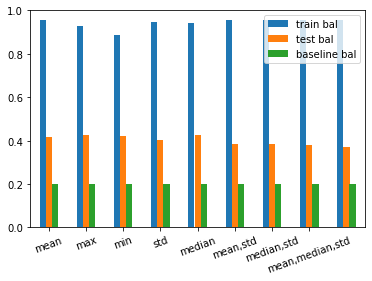

In [35]:
# Rename the column "test bal (base)" to "baseline bal"
# df_P5 = df_P5.rename(columns={"test bal (base)": "baseline bal"})
plt.figure(figsize=(15, 8))

df_red[["train bal", "test bal", "baseline bal"]].plot(
    kind="bar",
    # ax= 
)
reduct_method_list = ['mean', 'max', 'min', 'std','median','mean,std', 'median,std','mean,median,std']
plt.xticks(
    np.arange(8),
    reduct_method_list,
    rotation=20,
)
# plt.title("Mean scores (over all folds)")

# Save this plot
plt.savefig("results/results_reduction_methods.pdf", dpi=300, bbox_inches="tight")

plt.show()

In [38]:
df_reds = pd.read_csv('results/resreduct_method.csv') 
df_reds['baseline bal'] = 0.200
df_reds.rename(columns = {'test_results': 'test bal', 'train_results': 'train bal'}, inplace=True)
df_reds

,Unnamed: 0,test bal,train bal,reduct_method,baseline bal
0,1,0.410790,0.949573,mean,0.2
1,2,0.409220,0.922481,max,0.2
2,3,0.408544,0.877210,min,0.2
3,4,0.400299,0.939935,std,0.2
4,5,0.412589,0.939148,median,0.2
5,6,0.386857,0.950000,"mean,std",0.2
6,7,0.393883,0.949592,"median,std",0.2
7,8,0.377306,0.949683,"mean,median,max",0.2
8,9,0.380357,0.949896,"mean,median,std",0.2


In [14]:
df_save = pd.DataFrame()
reduct_method_list = ['demographics','mean', 'max', 'min', 'std','median','mean,std', 'median,std','mean,median,max','mean,median,std']
df_save['test_results'] = test_results
df_save['train_results'] = train_results
# df_save['test_errs'] = test_errs
# df_save['train_errs'] = train_errs
df_save['reduct_method'] = reduct_method_list
df_save.to_csv('results/resreduct_method.csv')

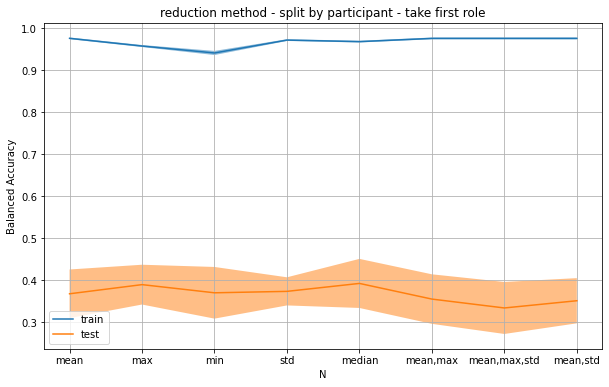

In [63]:
draw_train_result(
    test_results,
    train_results,
    test_errs,
    train_errs,
    reduct_method,
    title="reduction method - split by participant - take first role",
)


### 2. aggregate previous records with mean, not weighted

In [ ]:
previous_num_list = np.arange(0,15,1).tolist()
previous_num_list.insert(0, 'base')
train_results = []
test_results = []
train_errs = []
test_errs = []

metric_dict = train_cv(SPLIT_BY_PARTICIPANT=True, TEST_TAKE_FIRST=1, WEIGHTED=False, PREVIOUS_NUM=0, N_SPLIT=10, daily_reduction=['median'])
train_results.append(metric_dict['train_bal'].mean())
train_errs.append(metric_dict['train_bal'].std())
test_results.append(metric_dict['test_bal'].mean())
test_errs.append(metric_dict['test_bal'].std())

for num in previous_num_list[1:]:
    print('previous_num:',num)
    metric_dict = train_cv(PREVIOUS_NUM = num, ALL_PREVIOUS_DATA = False, SPLIT_BY_PARTICIPANT=True, WEIGHTED = False, TEST_TAKE_FIRST=1, N_SPLIT=10,daily_reduction=['median'])
    train_results.append(metric_dict['train_bal'].mean())
    train_errs.append(metric_dict['train_bal'].std())
    test_results.append(metric_dict['test_bal'].mean())
    test_errs.append(metric_dict['test_bal'].std())


In [52]:
test_errs

[0.06051553029727934,
 0.06899671872651653,
 0.06899671872651653,
 0.06899671872651653,
 0.06899671872651653,
 0.06899671872651653,
 0.06899671872651653,
 0.06899671872651653,
 0.06899671872651653,
 0.06899671872651653]

In [73]:
df_save = pd.DataFrame()
previous_num_list = [str(x) for x in previous_num_list]
df_save['test_results'] = test_results
df_save['train_results'] = train_results
df_save['test_errs'] = test_errs
df_save['train_errs'] = train_errs
df_save['aggregate_previous_num'] = previous_num_list
df_save.to_csv('results/aggregated_previous_rows_using_mean(median).csv')

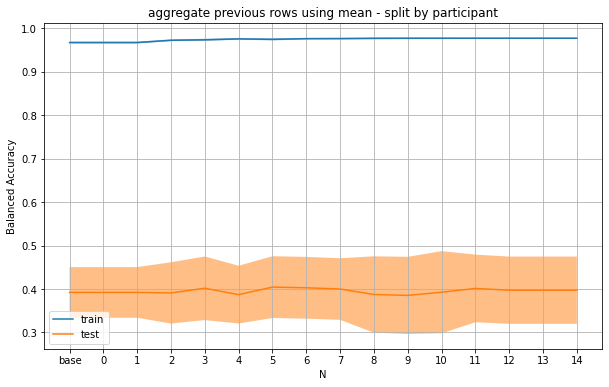

In [74]:
draw_train_result(
    test_results,
    train_results,
    test_errs,
    train_errs,
    previous_num_list,
    title="aggregate previous rows using mean - split by participant",
)


### 3. aggregate previous data with moving avarage (pandas.emw - exponentially weighted (EW) calculations)


In [48]:
halflife_list = [
    "base",
    'unweighted mean',
    "1 days",
    "3 days",
    "7 days",
    "10 days",
    "12 days",
    "14 days",
    "20 days",
    "30 days",
]
train_results = []
test_results = []

train_results, test_results =  train(
    TYPE="classification",
    TARGET="value",
    SPLIT_BY_PARTICIPANT=True,
    SEED=550,
    TEST_TAKE_FIRST=1,
    feature_selection=True,
    dailies_names = (),
    daily_reduction=["mean"],
    verbose=True,
    partition=partitions,
)
train_results.append(metric_dict["train_bal"].mean())
train_errs.append(metric_dict["train_bal"].std())
test_results.append(metric_dict["test_bal"].mean())
test_errs.append(metric_dict["test_bal"].std())


metric_dict = train_cv(
        WEIGHTED=False,
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        ALL_PREVIOUS_DATA=False,
        PREVIOUS_NUM=30,
        daily_reduction=["median"],
    )
train_results.append(metric_dict["train_bal"].mean())
train_errs.append(metric_dict["train_bal"].std())
test_results.append(metric_dict["test_bal"].mean())
test_errs.append(metric_dict["test_bal"].std())


for halflife in halflife_list[2:]:
    print(f"halflife length is: {halflife}")
    metric_dict = train_cv(
        WEIGHTED=True,
        WEIGHTED_DAYS=True,
        EWM_HALFLIFE=halflife,
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        daily_reduction=["median"],
    )
    train_results.append(metric_dict["train_bal"].mean())
    train_errs.append(metric_dict["train_bal"].std())
    test_results.append(metric_dict["test_bal"].mean())
    test_errs.append(metric_dict["test_bal"].std())


--- Split 0 ---
Random full accuracy: 18.52%
Train set:
Test set:
--- Split 1 ---
Random full accuracy: 19.29%
Train set:
Test set:
--- Split 2 ---
Random full accuracy: 19.38%
Train set:
Test set:
--- Split 3 ---
Random full accuracy: 21.10%
Train set:
Test set:
--- Split 4 ---
Random full accuracy: 21.10%
Train set:
Test set:
--- Split 5 ---
Random full accuracy: 22.14%
Train set:
Test set:
--- Split 6 ---
Random full accuracy: 20.76%
Train set:
Test set:
--- Split 7 ---
Random full accuracy: 21.27%
Train set:
Test set:
--- Split 8 ---
Random full accuracy: 22.57%
Train set:
Test set:
--- Split 9 ---
Random full accuracy: 19.38%
Train set:
Test set:
--- Split 0 ---
Random full accuracy: 20.24%
Train set:
Test set:
--- Split 1 ---
Random full accuracy: 20.07%
Train set:
Test set:
--- Split 2 ---
Random full accuracy: 22.14%
Train set:
Test set:
--- Split 3 ---
Random full accuracy: 21.10%
Train set:
Test set:
--- Split 4 ---
Random full accuracy: 18.95%
Train set:
Test set:
--- Split 

In [49]:
df_agg = pd.DataFrame(
    {
        'halflife_list': halflife_list,
        "train bal": train_results,
        "test bal": test_results,
        "train_errs": train_errs,
        "test_errs": test_errs,
    }
)

df_agg['baseline bal'] = 0.2
df_agg

,halflife_list,train bal,test bal,train_errs,test_errs,baseline bal
0,base,0.939148,0.412589,0.002899,0.060516,0.2
1,unweighted mean,0.954394,0.420677,0.002750,0.078263,0.2
2,1 days,0.952421,0.415772,0.002776,0.062475,0.2
3,3 days,0.954286,0.416131,0.002461,0.057176,0.2
4,7 days,0.954364,0.422836,0.002625,0.066644,0.2
5,10 days,0.954533,0.428673,0.002794,0.074135,0.2
6,12 days,0.954341,0.420688,0.002640,0.070555,0.2
7,14 days,0.954313,0.428618,0.002836,0.069948,0.2
8,20 days,0.954380,0.423945,0.002702,0.076218,0.2
9,30 days,0.954425,0.425517,0.002632,0.076739,0.2


<Figure size 1080x576 with 0 Axes>

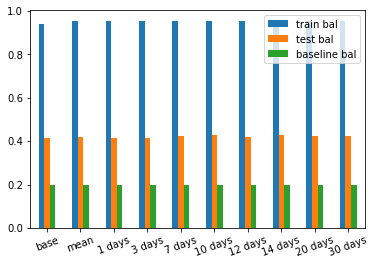

In [58]:
# Rename the column "test bal (base)" to "baseline bal"
# df_P5 = df_P5.rename(columns={"test bal (base)": "baseline bal"})
plt.figure(figsize=(15, 8))

df_agg[["train bal", "test bal", "baseline bal"]].plot(
    kind="bar",
    # ax= 
)
plt.xticks(
    np.arange(10),
    df_agg["halflife_list"],
    rotation=20,
)
# plt.title("Mean scores (over all folds)")

# Save this plot
plt.savefig("results/results_agg_previous.pdf", dpi=300, bbox_inches="tight")

plt.show()

In [76]:
df_save = pd.DataFrame()
df_save['test_results'] = test_results
df_save['train_results'] = train_results
df_save['test_errs'] = test_errs
df_save['train_errs'] = train_errs
df_save['halflife_list'] = halflife_list
df_save.to_csv('results/aggregated_previous_rows_using_moving_avg(median_halflife).csv')

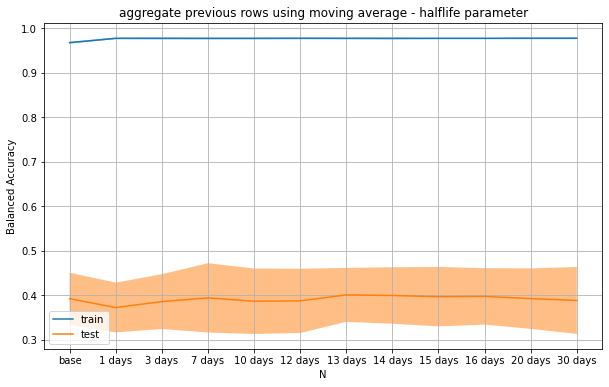

In [78]:
draw_train_result(
    test_results,
    train_results,
    test_errs,
    train_errs,
    halflife_list,
    title="aggregate previous rows using moving average - halflife parameter",
)


In [10]:
span_list = ['base', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30]
train_results = []
test_results = []
train_errs = []
test_errs = []


metric_dict = train_cv(
    SPLIT_BY_PARTICIPANT=True,
    TEST_TAKE_FIRST=1,
    WEIGHTED=False,
    PREVIOUS_NUM=0,
    N_SPLIT=10,
    daily_reduction=["median"],
)
train_results.append(metric_dict["train_bal"].mean())
train_errs.append(metric_dict["train_bal"].std())
test_results.append(metric_dict["test_bal"].mean())
test_errs.append(metric_dict["test_bal"].std())

for span in span_list[1:]:
    print(f"span length is: {span}")
    metric_dict = train_cv(
        WEIGHTED=True,
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        WEIGHTED_DAYS = False, 
        EWM_SPAN=span,
        daily_reduction=["median"],
    )
    train_results.append(metric_dict["train_bal"].mean())
    train_errs.append(metric_dict["train_bal"].std())
    test_results.append(metric_dict["test_bal"].mean())
    test_errs.append(metric_dict["test_bal"].std())


--- Split 0 ---
Random full accuracy: 20.92%
Train set:
Mean accuracy: 93.433%
Balanced accuracy: 93.557%
Test set:
Mean accuracy: 44.186%
Balanced accuracy: 38.141%
--- Split 1 ---
Random full accuracy: 21.79%
Train set:
Mean accuracy: 93.333%
Balanced accuracy: 93.472%
Test set:
Mean accuracy: 44.828%
Balanced accuracy: 53.025%
--- Split 2 ---
Random full accuracy: 20.14%
Train set:
Mean accuracy: 93.433%
Balanced accuracy: 93.408%
Test set:
Mean accuracy: 33.721%
Balanced accuracy: 30.911%
--- Split 3 ---
Random full accuracy: 21.61%
Train set:
Mean accuracy: 93.152%
Balanced accuracy: 93.739%
Test set:
Mean accuracy: 37.209%
Balanced accuracy: 44.000%
--- Split 4 ---
Random full accuracy: 19.01%
Train set:
Mean accuracy: 93.521%
Balanced accuracy: 93.780%
Test set:
Mean accuracy: 42.529%
Balanced accuracy: 45.648%
--- Split 5 ---
Random full accuracy: 20.92%
Train set:
Mean accuracy: 93.891%
Balanced accuracy: 94.002%
Test set:
Mean accuracy: 31.818%
Balanced accuracy: 30.827%
--- 

In [16]:
df_save = pd.DataFrame()
span_list = [str(x) for x in span_list]
df_save['test_results'] = test_results
df_save['train_results'] = train_results
df_save['test_errs'] = test_errs
df_save['train_errs'] = train_errs
df_save['span'] = span_list
df_save.to_csv('results/aggregated_previous_rows_using_moving_avg(median_span).csv')

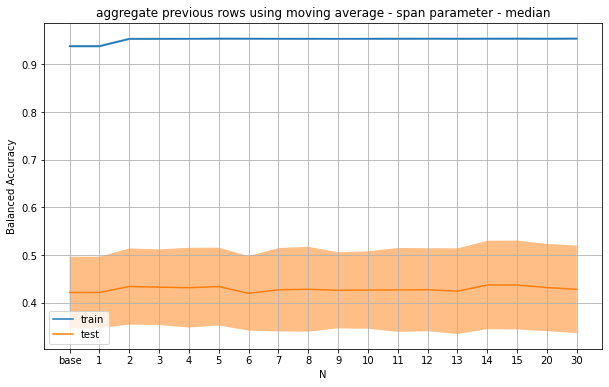

In [15]:
draw_train_result(
    test_results,
    train_results,
    test_errs,
    train_errs,
    span_list,
    title="aggregate previous rows using moving average - span parameter - median",
)

In [90]:
df = pd.read_csv('results/aggregated_previous_rows_using_moving_avg(median_halflife).csv')
df

,Unnamed: 0,test_results,train_results,test_errs,train_errs,halflife_list
0,0,0.392238,0.967507,0.058375,0.002070,base
1,1,0.372236,0.977214,0.055926,0.001781,1 days
2,2,0.385544,0.977185,0.061586,0.002004,3 days
3,3,0.393993,0.977096,0.077856,0.001911,7 days
4,4,0.386429,0.977123,0.073594,0.001907,10 days
5,5,0.387221,0.977268,0.072223,0.001751,12 days
6,6,0.400710,0.977184,0.060625,0.001808,13 days
7,7,0.399331,0.977113,0.063481,0.002050,14 days
8,8,0.396597,0.977185,0.066741,0.001589,15 days
9,9,0.397311,0.977185,0.063423,0.001589,16 days


In [93]:
metric_dict = train_cv(
        WEIGHTED=True,
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        WEIGHTED_DAYS = True, 
        EWM_HALFLIFE='12 days',
        daily_reduction=["mean"],
    )
metric_dict["test_bal"].mean()


--- Split 0 ---
Random full accuracy: 20.23%
Train set:
Mean accuracy: 97.749%
Balanced accuracy: 97.930%
Test set:
Mean accuracy: 52.326%
Balanced accuracy: 44.230%
--- Split 1 ---
Random full accuracy: 19.36%
Train set:
Mean accuracy: 97.559%
Balanced accuracy: 97.770%
Test set:
Mean accuracy: 50.575%
Balanced accuracy: 54.834%
--- Split 2 ---
Random full accuracy: 19.27%
Train set:
Mean accuracy: 97.749%
Balanced accuracy: 97.845%
Test set:
Mean accuracy: 36.047%
Balanced accuracy: 29.797%
--- Split 3 ---
Random full accuracy: 21.01%
Train set:
Mean accuracy: 97.561%
Balanced accuracy: 97.728%
Test set:
Mean accuracy: 43.023%
Balanced accuracy: 41.481%
--- Split 4 ---
Random full accuracy: 19.53%
Train set:
Mean accuracy: 97.653%
Balanced accuracy: 97.856%
Test set:
Mean accuracy: 48.276%
Balanced accuracy: 49.300%
--- Split 5 ---
Random full accuracy: 20.05%
Train set:
Mean accuracy: 98.120%
Balanced accuracy: 98.167%
Test set:
Mean accuracy: 36.364%
Balanced accuracy: 37.218%
--- 

0.40134033931565866

In [98]:
span_list = ['base', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,30]
train_results = []
test_results = []
train_errs = []
test_errs = []


metric_dict = train_cv(
    SPLIT_BY_PARTICIPANT=True,
    TEST_TAKE_FIRST=1,
    WEIGHTED=False,
    PREVIOUS_NUM=0,
    N_SPLIT=10,
    daily_reduction=["mean"],
)
train_results.append(metric_dict["train_bal"].mean())
train_errs.append(metric_dict["train_bal"].std())
test_results.append(metric_dict["test_bal"].mean())
test_errs.append(metric_dict["test_bal"].std())

for span in span_list[1:]:
    print(f"span length is: {span}")
    metric_dict = train_cv(
        WEIGHTED=True,
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        WEIGHTED_DAYS = False, 
        EWM_SPAN=span,
        daily_reduction=["mean"],
    )
    train_results.append(metric_dict["train_bal"].mean())
    train_errs.append(metric_dict["train_bal"].std())
    test_results.append(metric_dict["test_bal"].mean())
    test_errs.append(metric_dict["test_bal"].std())


--- Split 0 ---
Random full accuracy: 20.92%
Train set:
Mean accuracy: 97.280%
Balanced accuracy: 97.517%
Test set:
Mean accuracy: 48.837%
Balanced accuracy: 41.830%
--- Split 1 ---
Random full accuracy: 16.93%
Train set:
Mean accuracy: 97.183%
Balanced accuracy: 97.397%
Test set:
Mean accuracy: 37.931%
Balanced accuracy: 38.168%
--- Split 2 ---
Random full accuracy: 20.49%
Train set:
Mean accuracy: 97.280%
Balanced accuracy: 97.428%
Test set:
Mean accuracy: 36.047%
Balanced accuracy: 31.156%
--- Split 3 ---
Random full accuracy: 18.32%
Train set:
Mean accuracy: 97.092%
Balanced accuracy: 97.318%
Test set:
Mean accuracy: 32.558%
Balanced accuracy: 34.632%
--- Split 4 ---
Random full accuracy: 19.53%
Train set:
Mean accuracy: 97.183%
Balanced accuracy: 97.394%
Test set:
Mean accuracy: 47.126%
Balanced accuracy: 45.550%
--- Split 5 ---
Random full accuracy: 18.84%
Train set:
Mean accuracy: 97.650%
Balanced accuracy: 97.751%
Test set:
Mean accuracy: 29.545%
Balanced accuracy: 27.960%
--- 

In [101]:
df_save = pd.DataFrame()
span_list = [str(x) for x in span_list]
df_save['test_results'] = test_results
df_save['train_results'] = train_results
df_save['test_errs'] = test_errs
df_save['train_errs'] = train_errs
df_save['span'] = span_list
df_save.to_csv('results/aggregated_previous_rows_using_moving_avg(mean_span).csv')

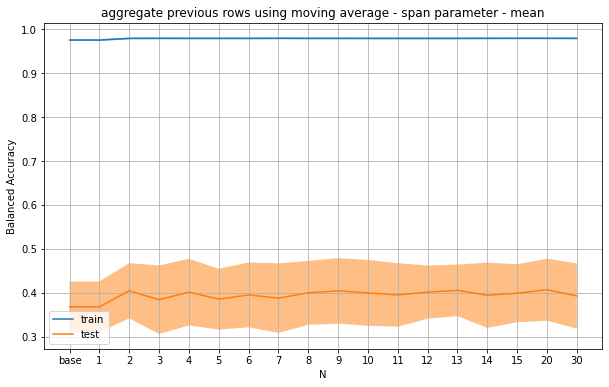

In [102]:
draw_train_result(
    test_results,
    train_results,
    test_errs,
    train_errs,
    span_list,
    title="aggregate previous rows using moving average - span parameter - mean",
)

In [103]:
halflife_list = [
    "base",
    "1 days",
    "3 days",
    "7 days",
    "10 days",
    "12 days",
    "13 days",
    "14 days",
    "15 days",
    "16 days",
    "20 days",
    "30 days",
]
train_results = []
test_results = []
train_errs = []
test_errs = []

metric_dict = train_cv(
    SPLIT_BY_PARTICIPANT=True,
    TEST_TAKE_FIRST=1,
    WEIGHTED=False,
    PREVIOUS_NUM=0,
    N_SPLIT=10,
    daily_reduction=["mean"],
)
train_results.append(metric_dict["train_bal"].mean())
train_errs.append(metric_dict["train_bal"].std())
test_results.append(metric_dict["test_bal"].mean())
test_errs.append(metric_dict["test_bal"].std())

for halflife in halflife_list[1:]:
    print(f"halflife length is: {halflife}")
    metric_dict = train_cv(
        WEIGHTED=True,
        EWM_HALFLIFE=halflife,
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        daily_reduction=["mean"],
    )
    train_results.append(metric_dict["train_bal"].mean())
    train_errs.append(metric_dict["train_bal"].std())
    test_results.append(metric_dict["test_bal"].mean())
    test_errs.append(metric_dict["test_bal"].std())


--- Split 0 ---
Random full accuracy: 19.53%
Train set:
Mean accuracy: 97.280%
Balanced accuracy: 97.517%
Test set:
Mean accuracy: 48.837%
Balanced accuracy: 41.830%
--- Split 1 ---
Random full accuracy: 19.18%
Train set:
Mean accuracy: 97.183%
Balanced accuracy: 97.397%
Test set:
Mean accuracy: 37.931%
Balanced accuracy: 38.168%
--- Split 2 ---
Random full accuracy: 20.75%
Train set:
Mean accuracy: 97.280%
Balanced accuracy: 97.428%
Test set:
Mean accuracy: 36.047%
Balanced accuracy: 31.156%
--- Split 3 ---
Random full accuracy: 18.66%
Train set:
Mean accuracy: 97.092%
Balanced accuracy: 97.318%
Test set:
Mean accuracy: 32.558%
Balanced accuracy: 34.632%
--- Split 4 ---
Random full accuracy: 20.23%
Train set:
Mean accuracy: 97.183%
Balanced accuracy: 97.394%
Test set:
Mean accuracy: 47.126%
Balanced accuracy: 45.550%
--- Split 5 ---
Random full accuracy: 19.62%
Train set:
Mean accuracy: 97.650%
Balanced accuracy: 97.751%
Test set:
Mean accuracy: 29.545%
Balanced accuracy: 27.960%
--- 

In [104]:
df_save = pd.DataFrame()
df_save['test_results'] = test_results
df_save['train_results'] = train_results
df_save['test_errs'] = test_errs
df_save['train_errs'] = train_errs
df_save['halflife_list'] = halflife_list
df_save.to_csv('results/aggregated_previous_rows_using_moving_avg(mean_halflife).csv')

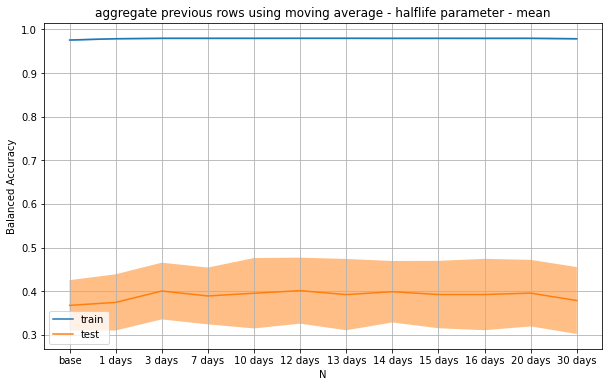

In [105]:
draw_train_result(
    test_results,
    train_results,
    test_errs,
    train_errs,
    halflife_list,
    title="aggregate previous rows using moving average - halflife parameter - mean",
)


## add new column that indicate the dates between two test dates
-> no help
code is in the **combined_additively** function at data_processing.py in the comment

In [8]:
metric_dict = train_cv(
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        daily_reduction=["mean"],
    )
metric_dict["test_bal"].mean()
#nothing

--- Split 0 ---
Random full accuracy: 17.80%
Train set:
Mean accuracy: 94.465%
Balanced accuracy: 94.716%
Test set:
Mean accuracy: 46.512%
Balanced accuracy: 40.963%
--- Split 1 ---
Random full accuracy: 21.79%
Train set:
Mean accuracy: 94.366%
Balanced accuracy: 94.643%
Test set:
Mean accuracy: 45.977%
Balanced accuracy: 53.692%
--- Split 2 ---
Random full accuracy: 22.14%
Train set:
Mean accuracy: 94.559%
Balanced accuracy: 94.768%
Test set:
Mean accuracy: 33.721%
Balanced accuracy: 28.712%
--- Split 3 ---
Random full accuracy: 20.49%
Train set:
Mean accuracy: 94.184%
Balanced accuracy: 94.685%
Test set:
Mean accuracy: 34.884%
Balanced accuracy: 39.991%
--- Split 4 ---
Random full accuracy: 20.75%
Train set:
Mean accuracy: 94.366%
Balanced accuracy: 94.643%
Test set:
Mean accuracy: 42.529%
Balanced accuracy: 46.114%
--- Split 5 ---
Random full accuracy: 19.18%
Train set:
Mean accuracy: 94.831%
Balanced accuracy: 95.009%
Test set:
Mean accuracy: 32.955%
Balanced accuracy: 30.427%
--- 

0.4104502111489688

In [7]:
metric_dict = train_cv(
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        daily_reduction=["median"],
    )
metric_dict["test_bal"].mean()
#nothing

--- Split 0 ---
Random full accuracy: 22.14%
Train set:
Mean accuracy: 93.433%
Balanced accuracy: 93.557%
Test set:
Mean accuracy: 44.186%
Balanced accuracy: 38.141%
--- Split 1 ---
Random full accuracy: 21.88%
Train set:
Mean accuracy: 93.333%
Balanced accuracy: 93.472%
Test set:
Mean accuracy: 44.828%
Balanced accuracy: 53.025%
--- Split 2 ---
Random full accuracy: 20.57%
Train set:
Mean accuracy: 93.433%
Balanced accuracy: 93.408%
Test set:
Mean accuracy: 33.721%
Balanced accuracy: 30.911%
--- Split 3 ---
Random full accuracy: 19.88%
Train set:
Mean accuracy: 93.152%
Balanced accuracy: 93.739%
Test set:
Mean accuracy: 37.209%
Balanced accuracy: 44.000%
--- Split 4 ---
Random full accuracy: 18.40%
Train set:
Mean accuracy: 93.521%
Balanced accuracy: 93.780%
Test set:
Mean accuracy: 42.529%
Balanced accuracy: 45.648%
--- Split 5 ---
Random full accuracy: 20.49%
Train set:
Mean accuracy: 93.891%
Balanced accuracy: 94.002%
Test set:
Mean accuracy: 31.818%
Balanced accuracy: 30.827%
--- 

0.4215718432243534

In [126]:
metric_dict = train_cv(
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        daily_reduction=["median"],
        WEIGHTED=True,
        WEIGHTED_DAYS=True,
        EWM_HALFLIFE = '14 days',
        feature_selection = True,
    )
metric_dict["test_bal"].mean()

--- Split 0 ---
Random full accuracy: 19.29%
Train set:
Test set:
--- Split 1 ---
Random full accuracy: 18.95%
Train set:
Test set:
--- Split 2 ---
Random full accuracy: 20.33%
Train set:
Test set:
--- Split 3 ---
Random full accuracy: 19.21%
Train set:
Test set:
--- Split 4 ---
Random full accuracy: 19.55%
Train set:
Test set:
--- Split 5 ---
Random full accuracy: 20.76%
Train set:
Test set:
--- Split 6 ---
Random full accuracy: 19.72%
Train set:
Test set:
--- Split 7 ---
Random full accuracy: 20.50%
Train set:
Test set:
--- Split 8 ---
Random full accuracy: 23.51%
Train set:
Test set:
--- Split 9 ---
Random full accuracy: 19.12%
Train set:
Test set:


0.4204905575446575

In [125]:
metric_dict = train_cv(
        SPLIT_BY_PARTICIPANT=True,
        TEST_TAKE_FIRST=1,
        N_SPLIT=10,
        daily_reduction=["median"],
        feature_selection = True
    )
metric_dict["test_bal"].mean()
#interval_date

--- Split 0 ---
Random full accuracy: 17.40%
Train set:
Test set:
--- Split 1 ---
Random full accuracy: 21.62%
Train set:
Test set:
--- Split 2 ---
Random full accuracy: 20.93%
Train set:
Test set:
--- Split 3 ---
Random full accuracy: 20.33%
Train set:
Test set:
--- Split 4 ---
Random full accuracy: 19.90%
Train set:
Test set:
--- Split 5 ---
Random full accuracy: 20.76%
Train set:
Test set:
--- Split 6 ---
Random full accuracy: 19.98%
Train set:
Test set:
--- Split 7 ---
Random full accuracy: 20.16%
Train set:
Test set:
--- Split 8 ---
Random full accuracy: 18.69%
Train set:
Test set:
--- Split 9 ---
Random full accuracy: 20.76%
Train set:
Test set:


0.4213704907566715